## Trigger Efficiency Overview

Once we have an idea of the analysis cuts we want for selecting single and multielectron pulses,
we should find the trigger efficiency as a function of pulse area to know if we need to make livetime corrections.

Briefly this means we need two histograms:

1. Pulse area spectrum of pulses passing analysis cuts
2. Pulse are spectrum of pulses passing analysis cuts which *also* have at least one trigger pulse coincident with them.

Chapter 6 in Brian Lenardo's thesis has a decent description of how to get these histograms. We need:

1. Pulses to be at least 3 $\mu s$ from other pulses. 
   *  `pulse.time_since_last` is a handy RQ with the time since the last pulse
2. Pulses to be 5 $\mu s$ after a trigger. 
   * `pulse.start_time` is the RQ for time since the trigger to the start of the pulse in $\mu s$
   * Since we don't know our trigger efficiency, selecting from the pre-trigger window could bias our results.
   * For example, if our true trigger efficiency is 25%, then the pre-trigger window will have *fewer* pulses of interest because 75% of the time we *would* have triggered on them
3. No S1s
   * A simple prompt fraction cut F500ns < 0.8 works for this; se `getse.ipynb`
   * F500ns is typically `pulse.fparameters[6]`

### Trigger Problems in Run 12

* The trigger configuration in Run 12 was supposed to be a 3-fold coincidence among the top 4 PMTs
* There was an error during the setup and it ended up being a 3-fold coincidence between 3 of the top 4, and the bottom PMT
* This error was not rectified until Aug 3rd by Jingke
* The first "good" file should be Run12_2790
* Treat other files with caution!

In [1]:
import uproot
import awkward as ak
import hist
from hist import Hist
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
plt.style.use("../assets/SetLZStyle.mplstyle")

In [2]:
f1_path = "/home/emiz/projects/projectdata/XeNu/Run12_trigger_efficiency/tmp_Run12_2724_20210720_12kVE13kVC0A_Top680_780_680_780VBot990V_Top3Fold_1200sccm_BgWPbShield.root"
pulse_data = uproot.open(f1_path)["pulse_data"].arrays()

## Cuts

* 3 $\mu s$ separation seems to be too large (poor statistics), use 0.5 $\mu$ s instead
* `not_s1` and `time_since last` do not apply to triggers since those look like S1s and can fire repeatedly for a pulse

In [3]:
pulse_data["fparameters"] = ak.pad_none(pulse_data.fparameters, 8, clip=True)
pulse_data["tparameters"] = ak.pad_none(pulse_data.tparameters, 8, clip=True)

after_trigger = pulse_data.start_time > 5

# Only use these cuts on pulses since triggers look like S1s and can bunch up repeatedly
isolated = pulse_data.time_since_last > 0.5
not_s1 = ak.enforce_type(ak.fill_none((pulse_data.fparameters[:, 6] < 0.8), 0), "bool")

pulses = pulse_data[(pulse_data.channel_id == -2) & after_trigger & isolated & not_s1]
triggers = pulse_data[(pulse_data.channel_id == 5) & after_trigger]

## Merging Pulse and Triggers

* Use `event_id` and `event_timestamp` together to uniquely identify events
  * `event_timestamp` is in seconds, which is why it isn't unique
  * This might fail to hold if data is taken spanning daylight savings
* Use inner join to reject events with only triggers or only pulses

In [4]:
key_cols = [
    "event_id",
    "event_timestamp",
]
pulse_df = ak.to_dataframe(pulses[key_cols + ["npe", "start_time", "end_time"]])
trigger_df = ak.to_dataframe(triggers[key_cols + ["peak_time"]])

Inner join with these keys gives every combination of trigger peak times and pulse intervals on an event-by-event basis.
In the worst case, this only checks for for pulse and trigger overlaps within an event, not across the whole file.

In [5]:
# | label : te-df-inner-join

merged_df = trigger_df.merge(pulse_df, on=key_cols, how="inner")
merged_df.head(3)

event_id  event_timestamp  peak_time        npe  start_time  end_time
0         5       1626812919      9.124  33.103590       6.736    10.736
1         5       1626812919      9.124  83.439986      16.524    21.828
2         5       1626812919      9.124  47.499900      23.792    28.088

## Check For Trigger Overlap

`Series.between` let's us check for overlapping triggers and pulses in a single vectorized operation. A pulse interval has a trigger if a trigger peak is between the pulse bounds.

In [6]:
merged_df["has_trigger"] = merged_df["peak_time"].between(
    merged_df["start_time"], merged_df["end_time"]
)

Selecting for pulses with a trigger produces duplicate entries. 
For example, if a pulse caused the trigger to fire three times, we should expect one entry
for each instance.
We can remove these entries by selecting distinct combinations of event ID, time, and pulse start times
to get unique entries for each pulse.

In [7]:
merged_df = merged_df[merged_df["has_trigger"] == True].drop_duplicates(
    subset=key_cols + ["start_time"]
)

## Efficiency Histogram

Now that we know which pulses had a trigger, we take the ratio of $\frac{\text{pulses triggered}}{\text{all pulses}}$
to get the trigger efficiency. This is most useful when done with histograms of pulse areas.

In [8]:
pulse_area = hist.axis.Regular(
    50,
    10,
    1000,
    name="npe",
    label="Pulse Area [npe]",
    transform=hist.axis.transform.log,
)

h_triggered = Hist(pulse_area, storage=hist.storage.Weight()).fill_flattened(
    npe=merged_df.npe.to_numpy()
)
h_all = Hist(pulse_area, storage=hist.storage.Weight()).fill_flattened(npe=pulses.npe)

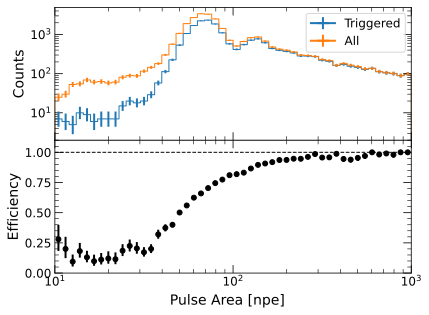

In [9]:
# | label : te-example

fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw=dict(hspace=0))

# hist.plot_ratio correctly calculates errors when dividing two weighted histograms
h_triggered.plot_ratio(
    h_all,
    rp_num_label="Triggered",
    rp_denom_label="All",
    rp_uncert_draw_type="line",
    rp_uncertainty_type="efficiency",
    ax_dict={"main_ax": axes[0], "ratio_ax": axes[1]},
    flow=None,
)
for ax in axes.flat:
    ax.set(xlabel="", xscale="log")
axes[0].set(yscale="log")
axes[1].get_lines()[1].set(marker=".")
fig.supxlabel(h_all.axes[0].label);  # fmt: skip